# Module 2, Lecture 5: Brief Introduction to Machine Learning

 
## Setup  

We begin by importing key libraries for math, data handling, plotting, and machine learning.  
Matplotlib settings are adjusted (line width, font size, tick size) to make future plots clearer and easier to read.  
 


In [2]:
############################################################
# Simple Decision Tree Implementation
############################################################

import math
from collections import Counter
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sys

# set line width
plt.rcParams['lines.linewidth'] = 4
# set font size for titles
plt.rcParams['axes.titlesize'] = 12
# set font size for labels on axes
plt.rcParams['axes.labelsize'] = 12
# set size of numbers on x-axis
plt.rcParams['xtick.labelsize'] = 12
# set size of numbers on y-axis
plt.rcParams['ytick.labelsize'] = 12
# set size of ticks on x-axis
plt.rcParams['xtick.major.size'] = 7
# set size of ticks on y-axis
plt.rcParams['ytick.major.size'] = 7
# set numpoints for legend``
plt.rcParams['legend.numpoints'] = 1
# set marker size
plt.rcParams['lines.markersize'] = 6

## Decision Tree Functions  

This code implements a simple decision tree from scratch:  

- **entropy / info_gain** – measure impurity and how much a feature reduces it.  
- **best_split** – selects the feature with highest information gain.  
- **majority_class** – fallback prediction if no clear split exists.  
- **build_tree** – recursively builds the tree using splits until labels are pure.  
- **classify** – uses a trained tree to predict a new sample.  
- **pretty_print_tree** – prints the tree structure in readable form.  


In [3]:
def entropy(data):
    labels = [label for _, label in data]
    total = len(labels)
    counts = Counter(labels)
    return -sum((count / total) * math.log2(count / total)
                for count in counts.values())

def info_gain(data, feature_index):
    base_entropy = entropy(data)
    subsets = {}
    for row in data:
        key = row[0][feature_index]
        subsets.setdefault(key, []).append(row)

    subset_entropy = sum((len(subset) / len(data)) * entropy(subset)
                         for subset in subsets.values()) 
    print(f'Entropy for {feature_names[feature_index]} = {subset_entropy:.3f}')
    return base_entropy - subset_entropy

def best_split(data):
    features = len(data[0][0])
    gains = [(i, info_gain(data, i)) for i in range(features)]
    return max(gains, key=lambda x: x[1])

def majority_class(data):
    labels = [label for _, label in data]
    return Counter(labels).most_common(1)[0][0]

def build_tree(data, depth=0):
    labels = [label for _, label in data]
    if len(set(labels)) == 1:
        return labels[0]
    if not data[0][0]:
        return majority_class(data)
    best_feature, gain = best_split(data)
    if gain == 0:
        return majority_class(data)
    tree = {'feature': best_feature, 'branches': {}}
    subsets = {}
    for row in data:
        key = row[0][best_feature]
        subsets.setdefault(key, []).append(row)
    for feature_val, subset in subsets.items():
        tree['branches'][feature_val] = build_tree(subset, depth + 1)
    return tree

def classify(tree, sample):
    while isinstance(tree, dict):
        feature = tree['feature']
        value = sample[feature]
        if value not in tree['branches']:
            return None
        tree = tree['branches'][value]
    return tree


def pretty_print_tree(tree, feature_names=None, indent=''):
    if isinstance(tree, str):
        print(indent + f"Predict: {tree}")
        return

    feature = tree['feature']
    branches = tree['branches']
    feature_name = f"Feature[{feature}]"
    if feature_names:
        feature_name = feature_names[feature]

    for branch_val, subtree in branches.items():
        print(f"{indent}if {feature_name} == {branch_val}:")
        pretty_print_tree(subtree, feature_names, indent + '    ')


## Training Data: Golf Examples  

We define two small datasets of past decisions:  

- **David’s history** – when David chose to play or not play golf based on weather features (outlook, temperature, humidity, windy).  
- **John’s history** – a similar record for John, but with some different choices.  

These labeled examples are the training data that our decision tree will use to learn patterns for predicting future play decisions.  


In [4]:
# Format: [([features], label)]
# Format: [outlook, temperature, humidity, windy]
david_history = [
    (['Sunny', 'Hot', 'High', 'False'], 'No'),
    (['Sunny', 'Hot', 'High', 'True'], 'No'),
    (['Overcast', 'Hot', 'High', 'False'], 'Yes'),
    (['Rainy', 'Mild', 'High', 'False'], 'Yes'),
    (['Rainy', 'Cool', 'Normal', 'False'], 'Yes'),
    (['Rainy', 'Cool', 'Normal', 'True'], 'No'),
    (['Overcast', 'Cool', 'Normal', 'True'], 'Yes'),
    (['Sunny', 'Mild', 'High', 'False'], 'No'),
    (['Sunny', 'Cool', 'Normal', 'False'], 'Yes'),
    (['Rainy', 'Mild', 'Normal', 'False'], 'Yes'),
    (['Sunny', 'Mild', 'Normal', 'True'], 'Yes'),
    (['Overcast', 'Mild', 'High', 'True'], 'Yes'),
    (['Overcast', 'Hot', 'Normal', 'False'], 'Yes'),
    (['Rainy', 'Mild', 'High', 'True'], 'No'),
]

john_history = [
    (['Sunny', 'Hot', 'High', 'False'], 'No'),
    (['Sunny', 'Hot', 'High', 'True'], 'No'),
    (['Overcast', 'Hot', 'High', 'False'], 'Yes'),
    (['Rainy', 'Mild', 'High', 'False'], 'Yes'),
    (['Rainy', 'Cool', 'Normal', 'False'], 'No'),
    (['Rainy', 'Cool', 'Normal', 'True'], 'No'),
    (['Overcast', 'Cool', 'Normal', 'True'], 'No'),
    (['Sunny', 'Mild', 'High', 'False'], 'No'),
    (['Sunny', 'Cool', 'Normal', 'False'], 'No'),
    (['Rainy', 'Mild', 'Normal', 'False'], 'Yes'),
    (['Sunny', 'Mild', 'Normal', 'True'], 'Yes'),
    (['Overcast', 'Mild', 'High', 'True'], 'Yes'),
    (['Overcast', 'Hot', 'Normal', 'False'], 'Yes'),
    (['Rainy', 'Mild', 'High', 'True'], 'No'),
    ]

## Building David’s Decision Tree  

Here we train a decision tree on **David’s history** using the `build_tree` function.  
- The `feature_names` list provides human-readable labels for splits.  
- `pretty_print_tree` outputs the learned tree structure, showing how decisions depend on weather features.  


In [6]:
feature_names = ['outlook', 'temperature', 'humidity', 'windy']
tree_david = build_tree(david_history)
print('The decision tree learned for David:')
pretty_print_tree(tree_david, feature_names, '  ')

Entropy for outlook = 0.694
Entropy for temperature = 0.911
Entropy for humidity = 0.788
Entropy for windy = 0.892
Entropy for outlook = 0.971
Entropy for temperature = 0.400
Entropy for humidity = 0.000
Entropy for windy = 0.951
Entropy for outlook = 0.971
Entropy for temperature = 0.951
Entropy for humidity = 0.951
Entropy for windy = 0.000
The decision tree learned for David:
  if outlook == Sunny:
      if humidity == High:
          Predict: No
      if humidity == Normal:
          Predict: Yes
  if outlook == Overcast:
      Predict: Yes
  if outlook == Rainy:
      if windy == False:
          Predict: Yes
      if windy == True:
          Predict: No


## Building John’s Decision Tree  

Now we train a decision tree on **John’s history**.  
- The tree is constructed from his past play decisions.  
- `pretty_print_tree` displays the structure, highlighting how John’s choices differ from David’s.  


In [7]:
tree_john = build_tree(john_history)
print('\nThe decision tree learned from John:')
pretty_print_tree(tree_john, feature_names, '  ')

Entropy for outlook = 0.836
Entropy for temperature = 0.679
Entropy for humidity = 0.985
Entropy for windy = 0.965
Entropy for outlook = 0.000
Entropy for temperature = 1.000
Entropy for humidity = 0.689
Entropy for windy = 0.689
Entropy for outlook = 0.792
Entropy for temperature = 0.918
Entropy for humidity = 0.667
Entropy for windy = 0.918
Entropy for outlook = 0.500
Entropy for temperature = 1.000
Entropy for humidity = 1.000
Entropy for windy = 1.000
Entropy for outlook = 1.000
Entropy for temperature = 1.000
Entropy for humidity = 1.000
Entropy for windy = 0.000

The decision tree learned from John:
  if temperature == Hot:
      if outlook == Sunny:
          Predict: No
      if outlook == Overcast:
          Predict: Yes
  if temperature == Mild:
      if humidity == High:
          if outlook == Rainy:
              if windy == False:
                  Predict: Yes
              if windy == True:
                  Predict: No
          if outlook == Sunny:
              Predi

### Visualizing the Custom Decision Tree
The following cell uses `networkx` and `matplotlib` to display the custom decision tree graphically. If you don't have `networkx` installed, run `!pip install networkx` in a notebook cell.

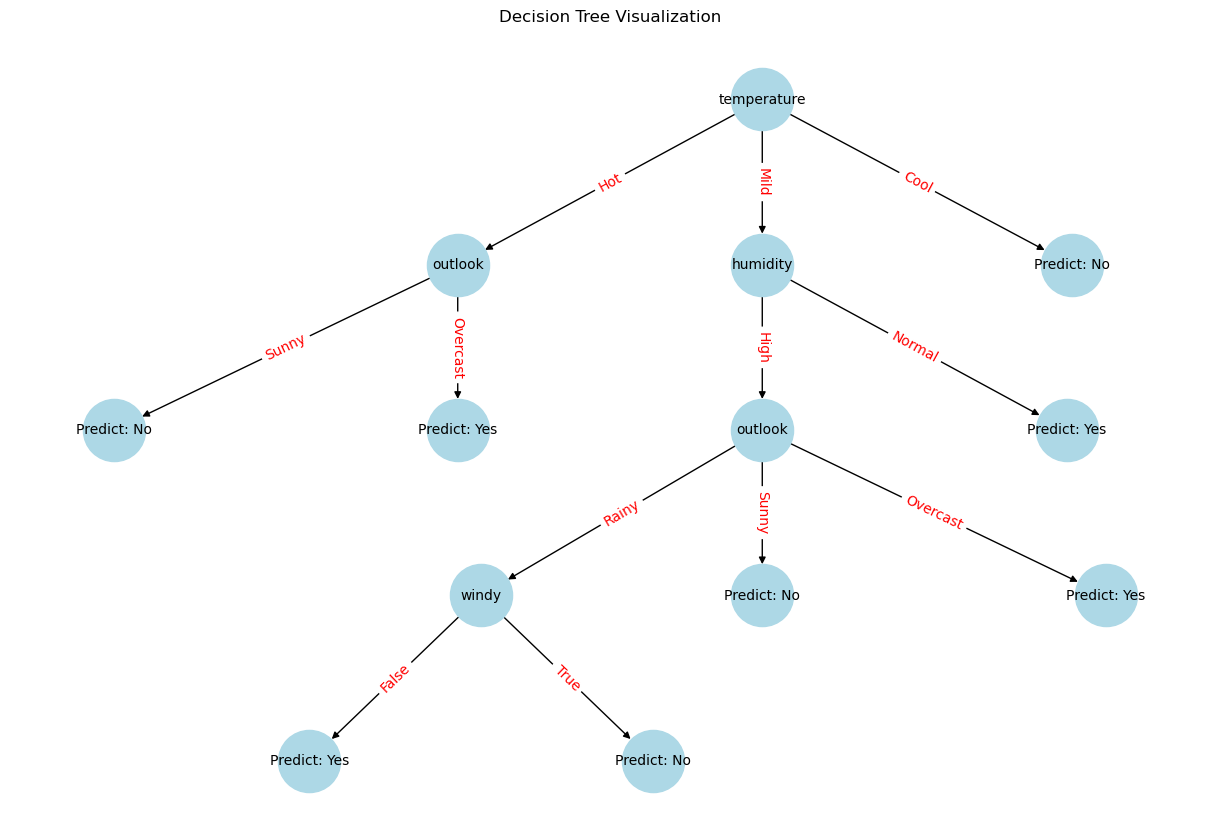

In [13]:
# If you don't have networkx installed, uncomment and run the next line
# !pip install networkx
import networkx as nx
def add_tree_to_graph(tree, graph, parent=None, edge_label=None, feature_names=None, node_id=[0]):
    if isinstance(tree, str):
        node_label = f"Predict: {tree}"
        graph.add_node(node_id[0], label=node_label)
        if parent is not None:
            graph.add_edge(parent, node_id[0], label=edge_label)
        node_id[0] += 1
        return node_id[0] - 1
    feature = tree['feature']
    feature_name = feature_names[feature] if feature_names else f"Feature[{feature}]"
    node_label = feature_name
    graph.add_node(node_id[0], label=node_label)
    this_node = node_id[0]
    if parent is not None:
        graph.add_edge(parent, this_node, label=edge_label)
    node_id[0] += 1
    for branch_val, subtree in tree['branches'].items():
        add_tree_to_graph(subtree, graph, this_node, str(branch_val), feature_names, node_id)
    return this_node
def plot_decision_tree_graph(tree, feature_names=None, figsize=(12,8)):
    G = nx.DiGraph()
    add_tree_to_graph(tree, G, feature_names=feature_names)
    try:
        pos = nx.nx_pydot.graphviz_layout(G, prog='dot')
    except (ImportError, AttributeError, Exception):
        pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')
    plt.figure(figsize=figsize)
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title('Decision Tree Visualization')
    plt.show()
# Example: visualize John's tree
plot_decision_tree_graph(tree_john, feature_names)

## Making Predictions  

We test both decision trees on a new weather example: `['Rainy', 'Cool', 'High', 'False']`.  
- The **David tree** and the **John tree** may give different predictions, since they were trained on different histories.  
- This shows how training data directly shapes the model’s behavior.  


In [6]:
sample = ['Rainy', 'Cool', 'High', 'False']
print("Prediction for sample using David tree:", classify(tree_david, sample))
print("Prediction for sample using John tree:", classify(tree_john, sample))

Prediction for sample using David tree: Yes
Prediction for sample using John tree: No


## Model Training and Data Generation  

- **train_model**: builds a random forest with a chosen number of trees and maximum depth, then fits it to training data.  
- **gen_cardiac_data**: creates synthetic patient records for classification tasks.  
  - Features are biased toward 0 (absence of a condition).  
  - Labels are generated by a `ground_truth` function.  
  - An optional `label_noise` flag flips some labels to mimic real-world data errors.  


In [7]:
## Code for building models

def train_model(X, Y, num_trees, max_depth):
    model = RandomForestClassifier(
        n_estimators=num_trees,
        max_depth=max_depth,
        max_features='sqrt',
        bootstrap=True)
    model.fit(X, Y)
    return model

In [ ]:
def gen_cardiac_data(num_examples, num_features, feature_vals, ground_truth):
    """Generate synthetic classification data
    num_examples : int > 0
    num_features : int > 0
    feature_vals : list of ints
    ground_truth : function that maps a feature vector to 0 or 1"""

    X, Y = [], []
    feature_vals = (0,0,0,0,0,1) # because not having condition more likely
    for _ in range(num_examples):
        x = []
        for n in range(num_features):
            x.append(random.choice(feature_vals))
        y = ground_truth(x)
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

# Version with label noise
def gen_cardiac_data(num_examples, num_features, feature_vals,
                         ground_truth, label_noise = False):
    X, Y = [], []
    feature_vals = (0,0,0,0,0,1) # because not having condition more likely
    for _ in range(num_examples):
        x = []
        for n in range(num_features):
            x.append(random.choice(feature_vals))
        if label_noise:
            y = (ground_truth(x) if random.random() < 0.8
                 else not ground_truth(x))
        else:
            y = ground_truth(x)
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    return X, Y


## Model Evaluation  

- **eval_model**: tests a trained random forest on given data, returning the fraction of correct predictions.  
- **model_cardiac_data**: runs multiple trials of training and testing on synthetic cardiac data.  
  - Generates training and test sets.  
  - Trains a random forest with specified parameters.  
  - Evaluates accuracy across trials and returns the average.  


In [9]:
def eval_model(forest, X, Y):
    correct = 0
    for i in range(len(X)):
        y_hat = forest.predict(np.array(X[i]).reshape(1, -1))
        if y_hat == Y[i]:
            correct += 1
    return correct/len(X)

def model_cardiac_data(ground_truth_str, num_examples, num_features,
                       num_trees, tree_depth, num_trials, label_noise = False):
    feature_vals = (0, 0, 0, 0, 1)
    test_size = 9000

    ground_truth = eval(ground_truth_str)
    accuracies = []
    for _ in range(num_trials):
        train_X, train_Y = gen_cardiac_data(num_examples, num_features,
                                            feature_vals, ground_truth,
                                            label_noise = label_noise)
        test_X, test_Y = gen_cardiac_data(test_size, num_features,
                                          feature_vals, ground_truth,
                                          label_noise = False)
        model = train_model(train_X, train_Y, num_trees, tree_depth)
        accuracies.append(eval_model(model, test_X, test_Y))
    return sum(accuracies)/num_trials

## Running Experiments on Cardiac Data  

- **eval_cardiac_examples**: trains models with increasing numbers of training examples and plots accuracy on a test set.  
  - Compares clean data vs. noisy labels.  
  - Shows how more training data improves performance.  

- **test_cardiac_data**: sets random seeds for reproducibility, defines a ground-truth risk rule, and runs the experiments.  

This produces accuracy curves that illustrate the effects of sample size and label noise on model learning.  


Try 25 training examples
Try 100 training examples
Try 300 training examples
Try 600 training examples
Try 1200 training examples
Try 2400 training examples
Try 4800 training examples
Try 25 training examples
Try 100 training examples
Try 300 training examples
Try 600 training examples
Try 1200 training examples
Try 2400 training examples
Try 4800 training examples



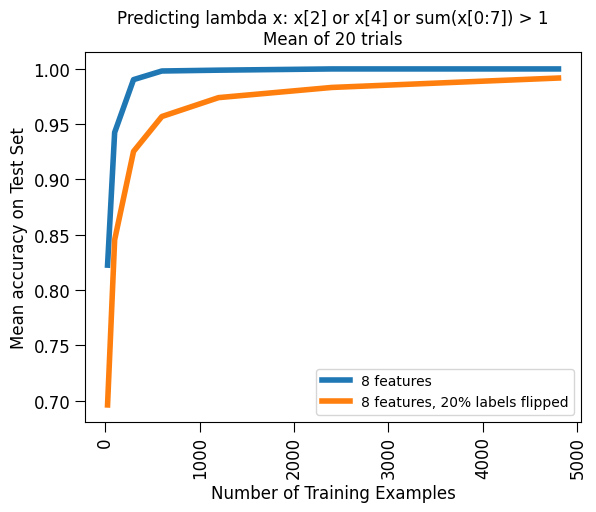

In [11]:
def eval_cardiac_examples(ground_truth_str, num_features, label_noise = False):
    num_trials = 20
    accuracies, x_vals = [], []
    for num_examples in (25, 100, 300, 600, 1200, 2400, 4800):
    # for num_examples in range(25, 1026, 100):
        accuracy = model_cardiac_data(ground_truth_str, num_examples,
                                         num_features, num_trees = 5,
                                         tree_depth = 10,
                                         num_trials = num_trials,
                                         label_noise = label_noise)
        print(f'Try {num_examples} training examples')
        x_vals.append(num_examples)
        accuracies.append(accuracy)
    label = (f'{num_features} features, 20% labels flipped' if label_noise
             else f'{num_features} features')
    plt.plot(x_vals, accuracies, label = label)
    plt.title(f'Predicting {ground_truth_str}\n'
              f'Mean of {num_trials} trials')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Mean accuracy on Test Set')
    plt.xticks(rotation = 90)
    plt.legend()

def test_cardiac_data():
    random.seed(0)
    np.random.seed(0)
     
    chas2 = 'lambda x: x[2] or x[4] or sum(x[0:7]) > 1'
    
    for num_features in (8,):
        eval_cardiac_examples(chas2, num_features)
        eval_cardiac_examples(chas2, num_features, label_noise = True)
        print('')

test_cardiac_data()


## Model Evaluation and Selection  

This section defines functions for evaluating classifiers:  

- **accuracy, precision, recall, f1_score** – common metrics for measuring prediction quality.  
- **conf_matrix** – visualizes performance in a 2×2 confusion matrix (TP, FP, TN, FN).  
- **split_data** – randomly partitions data into training and test sets.  
- **test_model** – applies a trained model to data, returning counts of TP, FP, TN, and FN.  

Together, these tools let us assess models beyond raw accuracy, showing trade-offs between false positives and false negatives.  


In [12]:
## code for evaluating and selecting models

def accuracy(tp, fp, tn, fn):
    return (tp+tn)/(tp+tn+fp+fn)

def precision(tp, fp, tn, fn):
    try:
        return tp/(tp + fp)
    except:
        return 0

def recall(tp, fp, tn, fn):
    try:
        return tp/(tp + fn)
    except:
        return 0
    
def f1_score(tp, fp, tn, fn):
    return ((2*precision(tp, fp, tn, fn)*recall(tp, fp, tn, fn))/
            (precision(tp, fp, tn, fn)+recall(tp, fp, tn, fn)))

def conf_matrix(tp, fp, tn, fn, title, caption = None):
    values = [[tp, fn],
              [fp, tn]]
    labels = [['TP', 'FN'],
              ['FP', 'TN']]
    colors = [['lightgreen', 'lightsalmon'],  # row: actual positive
              ['lightsalmon', 'lightgreen']]  # row: actual negative
    fig, ax = plt.subplots()
    # Draw colored rectangles
    for i in range(2):
        for j in range(2):
            rect = patches.Rectangle((j, i), 1, 1, facecolor=colors[i][j], edgecolor='black')
            ax.add_patch(rect)
            ax.text(j + 0.5, i + 0.5, f'{labels[i][j]}\n{values[i][j]}',
                    ha='center', va='center', fontsize=12)
            # Axis formatting
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])
    if caption == None:
        ax.set_xlabel('Predicted label')
    else:
        ax.set_xlabel(caption)
    ax.set_ylabel('True label')
    ax.set_title(title)
    ax.set_xlim(0, 2)
    ax.set_ylim(0, 2)
    ax.invert_yaxis()  # Make (0,0) the top-left
    ax.set_aspect('equal')
    plt.grid(False)
    plt.tight_layout()

def split_data(X, Y, train_frac):
    indices = list(range(len(X)))
    random.shuffle(indices)
    train_indices = indices[0:round(len(X)*train_frac)]
    test_indices = indices[len(train_indices):]
    train_X = [X[i] for i in train_indices]
    train_Y = [Y[i] for i in train_indices]
    test_X = [X[i] for i in test_indices]
    test_Y = [Y[i] for i in test_indices]
    return train_X, train_Y, test_X, test_Y
    
def test_model(forest, X, Y, verbose = 0):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(len(X)):
        y_hat = forest.predict(np.array(X[i]).reshape(1, -1))
        if verbose > 0:
            print(f'x = {X[i]}, y_hat = {y_hat}, y = {Y[i]}')
        if y_hat == 1 and Y[i] == 1:
            tp += 1
        elif y_hat == 1 and Y[i] == 0:
            fp += 1
        elif y_hat == 0 and Y[i] == 0:
            tn += 1
        else:
            fn += 1
    return tp, fp, tn, fn

## Titanic Dataset Preparation  

- **get_titanic_data** loads passenger data from CSV.  
- Drops non-informative columns (IDs, names, tickets, cabins).  
- Handles missing values by filling with median (Age) or mode (Embarked).  
- Encodes categorical variables: sex (0/1) and embarkation port (0/1/2).  
- Splits into **X** (features) and **Y** (labels: survived or not).  

This produces a clean dataset ready for training machine learning models.  


In [16]:
def get_titanic_data():
    df = pd.read_csv('data_lec5/titanic.csv')
    df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
    
    # Fill missing values
    df['Age'].fillna(df['Age'].median(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
    # Encode categorical variables
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    
    # Split into features and label
    X = df.drop('Survived', axis=1)
    Y = df['Survived']
    return X, Y

## Choosing Model Parameters  

- **choose_params** selects the best hyperparameters (number of trees, depth) from a dictionary of results.  
- Uses an objective function (e.g., accuracy) to compare models.  
- If two models perform equally, it prefers the simpler one (fewer nodes).  
- Prints the chosen parameters when `verbose=1`.  

This helps balance accuracy with model simplicity when tuning random forests.  


In [17]:
def choose_params(performance_dict, obj_fcn, verbose = 1):
    def simplicity(k):
        return performance_dict[k][1] # ave number of nodes in forests
    best_performance = -float('inf')
    simplest = float('inf')
    for k in performance_dict.keys():
        if (performance_dict[k][0] > best_performance) or\
           (performance_dict[k][0] == best_performance and simplicity(k) < simplest):
            best_performance = performance_dict[k][0]
            best_n = k[0]
            best_d = k[1]
            simplest = simplicity(k)
            if verbose > 0:
                print(f'Found params with mean {obj_fcn.__name__} on validation sets '
                      f'= {best_performance:.5f}: n = {best_n}, d = {best_d}, '
                      f'mean number of nodes = {round(simplest)}')
    return best_n, best_d, simplest

## Comparing Hyperparameters  

- **compare_params** evaluates different combinations of tree depth and number of trees.  
- For each parameter set:  
  - Trains a random forest on training data.  
  - Tests it on validation data using the chosen objective function (e.g., accuracy).  
  - Records performance and model complexity (average number of nodes).  
- Uses **choose_params** to pick the best balance of accuracy and simplicity.  
- Retrains the final model on combined training + validation data.  

This function automates hyperparameter tuning for random forests.  


In [18]:
def compare_params(train_X_list, train_Y_list, val_X_list, val_Y_list,
                   test_X_list, test_Y_list, tree_depths, num_trees,
                   obj_fcn, verbose = 0):
    x_vals = [(n, d) for n in num_trees for d in tree_depths]
    val_evals = {}
    for params in x_vals:
        eval_vals, eval_nodes = [], []
        for i in range(len(train_X_list)): # number of trials
            train_X, train_Y, val_X, val_Y =\
                train_X_list[i], train_Y_list[i], val_X_list[i], val_Y_list[i]
            model = train_model(train_X, train_Y, params[0], params[1])
            tp, fp, tn, fn = test_model(model, val_X, val_Y)
            eval_vals.append(obj_fcn(tp, fp, tn, fn))
            total_nodes = sum(model.tree_.node_count for model in model.estimators_)
            eval_nodes.append(total_nodes)
        val_evals[params] = (sum(eval_vals)/len(eval_vals),
                             sum(eval_nodes)/len(eval_nodes))
    best_n, best_d, num_nodes = choose_params(val_evals, obj_fcn, verbose)
    if verbose > 0:
        print(f'Best model found: trees = {best_n}, depth = {best_d}, '
          f'nodes = {round(num_nodes)}')
    return train_model(train_X + val_X, train_Y + val_Y, best_n, best_d)

## Building and Testing Models  

- **build_and_test** automates the full modeling workflow:  
  - Splits data into training, validation, and test sets (multiple trials).  
  - Searches over candidate tree depths and number of trees.  
  - Selects the best parameters using **compare_params** and the chosen objective function.  
  - Evaluates the final model on the test set.  
  - Displays results with a confusion matrix.  

This function ties together training, validation, and testing to evaluate random forest performance.  


In [19]:
def build_and_test(X, Y, objective, title, test_X, test_Y, verbose = 0):
    tree_depths = [2,4,8,16,32,64]
    num_trees = [1,5,9,15,25,35,45,95]
    num_trials = 2
    train_X_list, train_Y_list, val_X_list, val_Y_list = [],[],[],[]
    test_X_list, test_Y_list = [], []
    for _ in range(num_trials):
        train_X, train_Y, val_X, val_Y = split_data(X, Y, .8)
        train_X_list.append(train_X)
        train_Y_list.append(train_Y)
        val_X_list.append(val_X)
        val_Y_list.append(val_Y)
        test_X_list.append(test_X)
        test_Y_list.append(test_Y)
    model = compare_params(train_X_list, train_Y_list, val_X_list, val_Y_list,
                   test_X_list, test_Y_list, tree_depths, num_trees,
                   obj_fcn = objective)
    max_depth_tree = max(tree.tree_.max_depth for tree in model.estimators_)
    tp, fp, tn, fn = test_model(model, test_X, test_Y)
    title = (f'{title} in test set\n'
               f'Model chosen to optimize {objective.__name__}\n'
               f'Random forest of {len(model.estimators_)} trees '
               f'with max depth {max_depth_tree}')
    conf_matrix(tp, fp, tn, fn, title)

## Testing on the Titanic Dataset  

- **test_titanic** runs the full pipeline on Titanic survival data.  
  - Loads and preprocesses the dataset.  
  - Splits into training and test sets.  
  - Trains and evaluates random forests while optimizing for different objectives:  
    - Accuracy  
    - Recall  
    - Precision  
    - F1-score  
- For each case, the chosen model is tested and results are shown with a confusion matrix.  

This demonstrates how evaluation goals affect model selection and outcomes.  


/var/folders/jw/mzldzx895v9180t6dv1vz9qw0000gp/T/ipykernel_43644/538215056.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/jw/mzldzx895v9180t6dv1vz9qw0000gp/T/ipykernel_43644/538215056.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

Positive fraction = 0.38

Optimizing for accuracy

Optimizing for recall

Optimizing for precision

Optimizing for f1_score



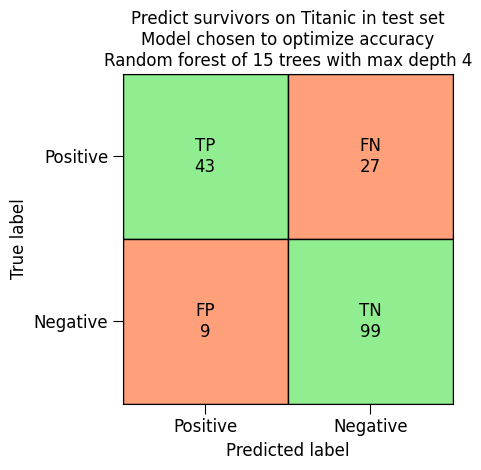

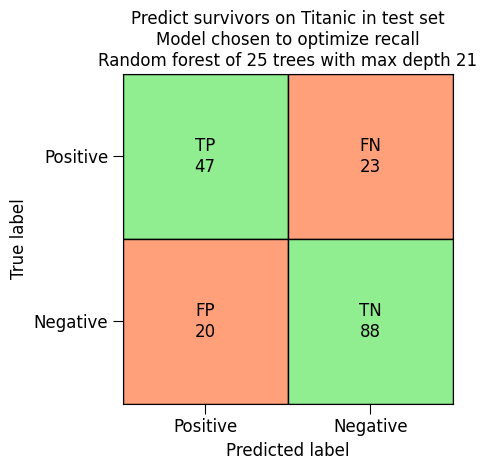

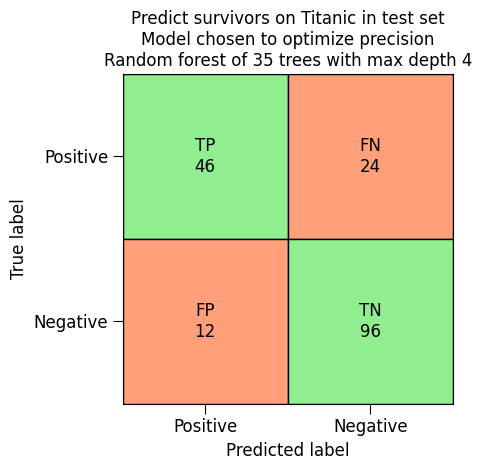

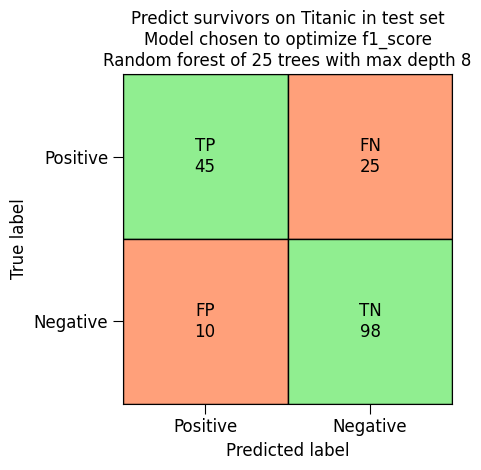

In [20]:
def test_titanic():
    random.seed(0)
    np.random.seed(0)
    X, Y = get_titanic_data()
    X = X.values.tolist()
    Y = Y.values.tolist()
    print(f'Positive fraction = {sum(Y)/len(Y):.2f}\n')
    train_X, train_Y, test_X, test_Y = split_data(X, Y, 0.8)
    for obj_fcn in (accuracy, recall, precision, f1_score):
        print(f'Optimizing for {obj_fcn.__name__}')
        build_and_test(train_X, train_Y, obj_fcn, 'Predict survivors on Titanic',
                       test_X, test_Y)
        print('')

test_titanic()
